**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [2]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [3]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [5]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [6]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [7]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [8]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

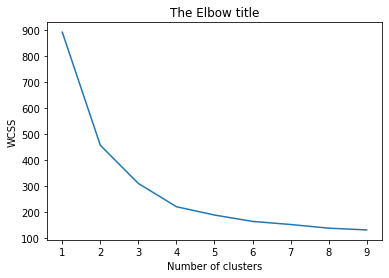

In [9]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [10]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [11]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [12]:
df_kmeans

,KMeans ID,texts
0,0,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...


In [13]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [14]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [15]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [16]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [17]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [18]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [58]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน'
                ,'ทาน' ,'กิน' ,'สั่ง' ,'เลือก' ,'ซื้อ' ,'รับประทาน' ,'แก้' ,'ดิชั้น' ,"['" ,'ดิ' ,'ช้ัน' ,'ทบ' ,'น' ,'ดังนั้น'
                ,'(' ,')' ,'ดื่ม' ,'พันธุ์' ,'โมง' ,'tamp' ,'เรื่อง' ,'review' ,'เฉพาะเรื่อง'
                , 'บาท' ,'สันทัด' ,'nTamp' ,'โถม' ,'ย้ำ' ,'อาหาร', ':' ,"']"
                , 'คน' ,"','" ,'นั่ง' ,'ผม' ,'ลอง' ,'นะคะ' ,'-' ,'ยังมี' ,'ร่างกาย' ,'เมล็ด' ,'ยังมี' ,'สำหรับ' ,'นิยม' ,'โอเค' ,'หันไป' ,'พี่' ,'งัั้น' ,'ตั้งแต่แรก'
                ,'--' ,'เจอ' ,'อีกแล้ว' ,'ช้อน' ,'มีผลต่อ' ,'รอบ'
]
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [48]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [49]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(อร่อย, 9), (รีวิว, 7), (บ้าน, 5), (ร้านกาแฟ,..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 11), (กก, 7), (อร่อย, 6), (ซอย, 6..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
3,3,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[ชอบ, Macchiato, เป็นประจำ, นึง, เด, ArtofCoff...","[(ร้านกาแฟ, 22), (กาแฟ, 19), (ชอบ, 8), (คาเฟ่,..."


In [50]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('อร่อย', 9), ('รีวิว', 7), ('บ้าน', 5), ('ร้านกาแฟ', 5), ('กาแฟ', 5), ('กก', 5), ('ชอบ', 4), ('ร้านอาหาร', 4), ('มีโอกาส', 3), ('ถนน', 3)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 11), ('กก', 7), ('อร่อย', 6), ('ซอย', 6), ('ราคา', 5), ('สวัสดี', 4), ('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ร้า', 3), ('ตั้งอยู่', 3), ('รีวิว', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ไหม', 2)]

Cluster ID : 3

Most common words include : [('ร้านกาแฟ', 22), ('กาแฟ', 19), ('ชอบ', 8), ('คาเฟ่', 6), ('แวะ', 6), ('น่ารัก', 5), ('เจอ', 5), ('นึง', 4), ('อ', 4), ('เบเกอรี่', 4)]



**Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [51]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [52]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [53]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [59]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 508), ('รสชาติ', 407), ('ดี', 347), ('กาแฟ', 311), ('เมนู', 309), ('ราคา', 273), ('ชา', 262), ('ชอบ', 229), ('หวาน', 206), ('จาน', 196)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('มีรส', 2), ('หวาน', 2), ('เย็น', 2), ('วิตามิน', 2), ('สีแดง', 2), ('ผลไม้', 2)]

Cluster ID : 2

Most common words include : [('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ('เวลา', 1), ('เย็น', 1), ('แม่ศรี', 1), ('เรือน', 1), ('โฮมโปร', 1), ('แขก', 1)]

Cluster ID : 3

Most common words include : [('นม', 3), ('แน่น', 2), ('เท', 2), ('ขนม', 1), ('กาแฟร้อน', 1), ('มากเกินไป', 1), ('รอบ', 1), ('มีผลต่อ', 1), ('ช๊อต', 1), ('กาแฟ', 1)]



**Step 4 - result discussion**

Cluster ID : 0
น่าจะเป็นคาเฟ่
เครื่องดื่ม กาแฟ ชา และเค้ก อร่อย รสชาติดี บรรยากาศดี

Cluster ID : 1
น่าจะเป็นร้านน้ำปั่น
นำ้แตงโมปั่นมีเนื้อ รสหวาน เย็น มีวิตามิน มีประโยชน์  ช่วยในการแก้กระหาย ล้างโรค

Cluster ID : 2
ร้านแม่ศรีเรือน ที่ Homepro
พนักงานบริการแย่มาก เอาแต่ยืนคุยกัน และกระแทกลูกค้า

Cluster ID : 3
น่าจะเป็นร้านกาแฟ
มีการใส่ส่วนผสมของกาแฟมากเกินไปทำให้รสชาติกาแฟเสีย
